In [1]:
import os
import re
import glob
import xarray as xr
import numpy as np
from pathlib import Path
from typing import Union, Optional, Callable
from tqdm import tqdm
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster, progress
import cmcrameri.cm as cmc

In [2]:
data_dir = "/scratch/opodriscoll/data/ERA5"

def preprocess_drop_coord(ds: xr.Dataset, coord_to_drop: str|list[str] = ["expver", "surface"]):
    return ds.drop_vars(coord_to_drop, errors='ignore')

## Open .zarr files 

In [5]:
list_files = glob.glob(str(data_dir) + "/*02?_temperature.zarr") # for temperature at pressure levels specifically
# list_files = glob.glob(str(data_dir) + "/*.zarr")
list_files.sort()
list_files

['/scratch/opodriscoll/data/ERA5/2020_temperature.zarr',
 '/scratch/opodriscoll/data/ERA5/2021_temperature.zarr']

In [6]:
ds = xr.open_mfdataset(list_files, engine="zarr", preprocess=preprocess_drop_coord)

## Compute Lower Tropospheric Stability (LTS) and Estimated Inversion Strength (EIS) from ERA5 pressure levels

In [11]:
from CMOD_analysis.atmosphere import estimated_inversion_strength, calculate_LTS
import pandas as pd

In [8]:
ds_season = ds.sel(valid_time=slice("2020-01-01", "2020-12-31")).groupby("valid_time.season").mean("valid_time")
ds_season = ds_season.compute()
ds_season

<xarray.Dataset> Size: 90MB
Dimensions:         (season: 4, latitude: 561, longitude: 1440,
                     pressure_level: 4)
Coordinates:
  * latitude        (latitude) float64 4kB 70.0 69.75 69.5 ... -69.75 -70.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    number          int64 8B 0
  * pressure_level  (pressure_level) float64 32B 1e+03 925.0 850.0 700.0
  * season          (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    d2m             (season, latitude, longitude) float32 13MB 250.5 ... 257.0
    sst             (season, latitude, longitude) float32 13MB 271.5 ... 271.5
    t               (season, pressure_level, latitude, longitude) float32 52MB ...
    t2m             (season, latitude, longitude) float32 13MB 253.4 ... 259.9
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-10-09T17:56 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [13]:
T_700 = ds_season['t'].sel(pressure_level = 700)
T_850 = ds_season['t'].sel(pressure_level = 850)
T_925 = ds_season['t'].sel(pressure_level = 925)
T_sfc = ds_season['sst']
z0 = 0
RH = 0.8

EISs = estimated_inversion_strength(
    T_700=T_700, 
    T_850=T_850, 
    T_925=T_925, 
    T_sfc=T_sfc, 
    z=z0, 
    RH=RH,
)

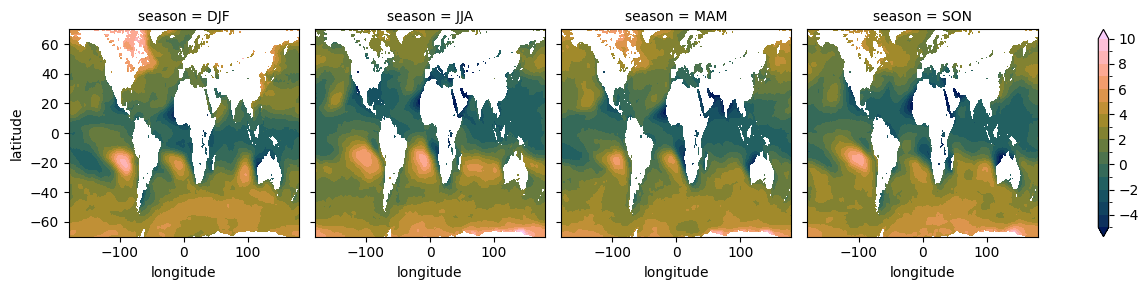

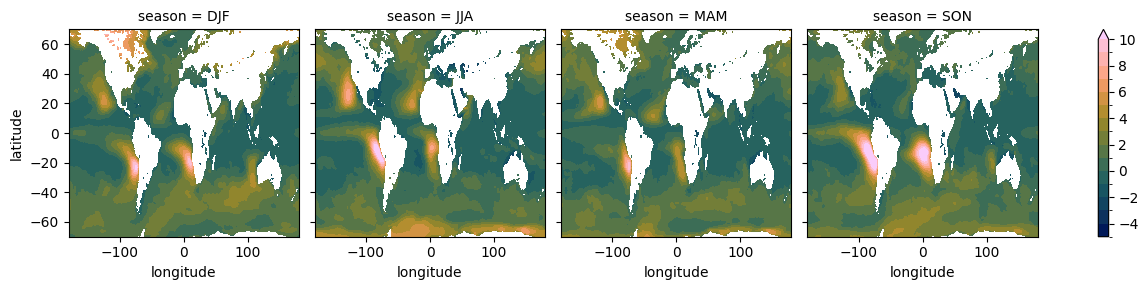

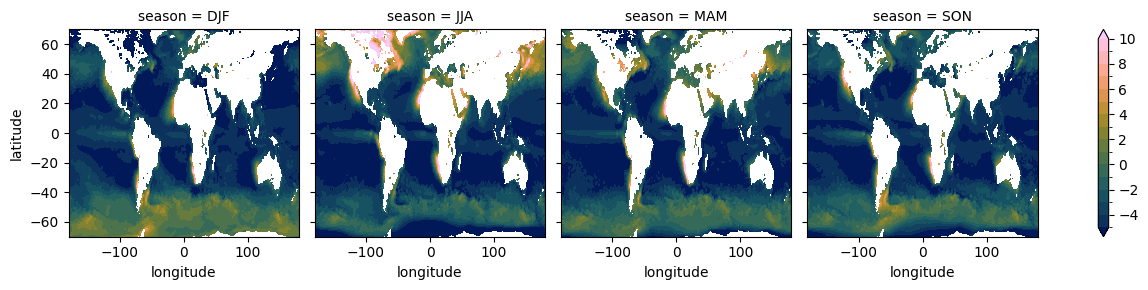

In [14]:
levels = 16
vmin = -5
cmap = cmc.batlow
EISs[0].plot.contourf(x="longitude", y="latitude", col="season", col_wrap=4, levels = levels, vmin=vmin, vmax = 10, cmap=cmap)
EISs[1].plot.contourf(x="longitude", y="latitude", col="season", col_wrap=4, levels = levels, vmin=vmin, vmax = 10, cmap=cmap)
EISs[2].plot.contourf(x="longitude", y="latitude", col="season", col_wrap=4, levels = levels, vmin=vmin, vmax = 10, cmap=cmap)

## Co-locate with dataframe points

In [15]:
file_name = "/scratch/opodriscoll/data/Sentinel-1/dataframes/df_w_highres_latent.csv"
df = pd.read_csv(file_name)
df.head(5)

,Unnamed: 0,index,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,...,median_75th,std_75th,mad_75th,S_windfield_xi_mean,S_windfield_xi_norm_std,S_sigma0_xi_mean,S_sigma0_xi_norm_std,inertial_subrange_length,energy_dir_range,slhf_highres
0,0,43,44,wv2,-101.826509085 -25.6805796738,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.634714,WS,...,62.0,60.758867,46.0,0.001682,0.352548,7.426597e-08,0.359761,2299.399624,51.5,-248.343156
1,1,2,3,wv1,157.487679483 46.6362002612,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.525564,AF,...,68.5,46.749110,45.5,0.000304,0.203705,1.649799e-07,0.200994,2523.062585,29.5,-7.299904
2,2,103,104,wv2,-126.149245849 24.9142669613,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.992728,OF,...,60.0,93.193627,51.0,0.001938,0.314485,1.243485e-07,0.315330,2468.989533,36.5,-188.296463
3,3,81,82,wv2,-151.467738318 7.75917557303,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.690646,OF,...,69.0,49.464820,41.0,0.000608,0.235655,7.722955e-09,0.239126,1056.764370,33.5,-108.323471
4,4,19,20,wv2,156.450687878 35.3909018142,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.674053,SI,...,19.0,72.127456,19.0,0.005072,0.171388,2.604131e-07,0.149163,2608.300898,26.0,-345.934569


In [16]:
# Get the corresponding coordinate values
valid_times = df['datetime_imagette'].values#
latitudes = df['lat_sar'].values#
longitudes = df['lon_sar'].values#

In [17]:
p = ds.sel(
    valid_time=xr.DataArray(valid_times, dims='points'),
    latitude=xr.DataArray(latitudes, dims='points'),
    longitude=xr.DataArray(longitudes, dims='points'),
    method='nearest'
).compute()
p

<xarray.Dataset> Size: 13MB
Dimensions:         (points: 249496, pressure_level: 4)
Coordinates:
    latitude        (points) float64 2MB -25.75 46.75 25.0 ... -33.75 -17.5
    longitude       (points) float64 2MB -101.8 157.5 -126.2 ... 175.5 -171.8
    number          int64 8B 0
  * pressure_level  (pressure_level) float64 32B 1e+03 925.0 850.0 700.0
    valid_time      (points) datetime64[ns] 2MB 2021-08-06T12:00:00 ... 2020-...
Dimensions without coordinates: points
Data variables:
    d2m             (points) float32 998kB 282.0 275.0 284.9 ... 282.1 298.2
    sst             (points) float32 998kB 293.1 277.1 292.2 ... 289.0 302.9
    t               (points, pressure_level) float32 4MB 288.2 281.9 ... 283.5
    t2m             (points) float32 998kB 290.6 277.1 289.5 ... 287.1 300.0
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-10-09T17:56 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [19]:
T_700 = p['t'].sel(pressure_level = 700)
T_850 = p['t'].sel(pressure_level = 850)
T_925 = p['t'].sel(pressure_level = 925)
T_sfc = p['sst']
z0 = 0
RH = 0.8

EIS_700_850, EIS_850_925, EIS_925_LCL = estimated_inversion_strength(
    T_700=T_700, 
    T_850=T_850, 
    T_925=T_925, 
    T_sfc=T_sfc, 
    z=z0,
    RH=RH,
)

LTS_700_850 = calculate_LTS(T_700, T_850)
LTS_850_925 = calculate_LTS(T_850, T_925)
LTS_925_sfc = calculate_LTS(T_925, T_sfc)

EIS_700_850.name = 'EIS_700_850'
EIS_850_925.name = 'EIS_850_925'
EIS_925_LCL.name = 'EIS_925_LCL'

LTS_700_850.name = 'LTS_700_850'
LTS_850_925.name = 'LTS_850_925'
LTS_925_sfc.name = 'LTS_925_sfc'

In [23]:
list_parameters = [
   EIS_700_850, 
   EIS_850_925, 
   EIS_925_LCL, 
   LTS_700_850, 
   LTS_850_925, 
   LTS_925_sfc
                  ]

names_parameters = [i.name for i in list_parameters]

df_list = [x.to_dataframe() for x in list_parameters]

In [27]:
df_EIS_LTS = pd.concat(df_list, axis=1, join="inner")
df_EIS_LTS = df_EIS_LTS.loc[:,~df_EIS_LTS.columns.duplicated()].copy()
df_EIS_LTS[names_parameters]

,EIS_700_850,EIS_850_925,EIS_925_LCL,LTS_700_850,LTS_850_925,LTS_925_sfc
points,,,,,,
0,5.857664,-2.750714,-8.098625,-2.452332,-6.067566,-11.273499
1,6.474605,7.778646,-1.655310,-3.692383,3.381805,-5.417755
2,0.707977,7.075297,-8.176709,-7.352570,3.433411,-11.235901
3,0.104409,-0.660133,-4.988121,-6.849060,-3.631470,-7.731445
4,1.147007,-0.930965,-13.019023,-7.732758,-4.778442,-16.631104
...,...,...,...,...,...,...
249491,0.889936,1.615087,-3.960903,-6.464050,-1.560089,-6.803009
249492,-0.607096,-1.134621,-3.703296,-7.603821,-4.148376,-6.508057
249493,-1.143975,-0.299823,-4.112803,-8.137146,-3.354523,-6.920929


In [28]:
list_df_both = [df, df_EIS_LTS[names_parameters]]
df_comb = pd.concat(list_df_both, axis=1)
df_comb.head(5)

,Unnamed: 0,index,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,...,S_sigma0_xi_norm_std,inertial_subrange_length,energy_dir_range,slhf_highres,EIS_700_850,EIS_850_925,EIS_925_LCL,LTS_700_850,LTS_850_925,LTS_925_sfc
0,0,43,44,wv2,-101.826509085 -25.6805796738,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.634714,WS,...,0.359761,2299.399624,51.5,-248.343156,5.857664,-2.750714,-8.098625,-2.452332,-6.067566,-11.273499
1,1,2,3,wv1,157.487679483 46.6362002612,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.525564,AF,...,0.200994,2523.062585,29.5,-7.299904,6.474605,7.778646,-1.655310,-3.692383,3.381805,-5.417755
2,2,103,104,wv2,-126.149245849 24.9142669613,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.992728,OF,...,0.315330,2468.989533,36.5,-188.296463,0.707977,7.075297,-8.176709,-7.352570,3.433411,-11.235901
3,3,81,82,wv2,-151.467738318 7.75917557303,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.690646,OF,...,0.239126,1056.764370,33.5,-108.323471,0.104409,-0.660133,-4.988121,-6.849060,-3.631470,-7.731445
4,4,19,20,wv2,156.450687878 35.3909018142,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.674053,SI,...,0.149163,2608.300898,26.0,-345.934569,1.147007,-0.930965,-13.019023,-7.732758,-4.778442,-16.631104


In [29]:
df_comb.to_csv("/scratch/opodriscoll/data/Sentinel-1/dataframes/df_w_highres_latent_EIS_LTS.csv", index = False)